In [2]:
import numpy as np
import pandas as pd
import biosignalsnotebooks as bsnb
import neurokit2 as nk
from scipy import signal
from matplotlib import pyplot as plt

# wavelets
import pywt
from pywt import swt, iswt, wavedec, waverec # package on Wavelet decomposition algorithms
from skimage.restoration import denoise_wavelet
from copy import deepcopy

# data pull
import sys
import biosignal_processing_package as rndSignal
repo = '/root/repos/biosignal_processing_package/'
sys.path.insert(1, repo + 'code/data_pull/functions')

In [3]:
# temporary function for plotting signals
def plot_signal(clean_signal, label = None):
    t = np.linspace(0, len(clean_signal), len(clean_signal))
    plt.plot(t, clean_signal, label = label)
    plt.legend(title="window length")

In [4]:
# import data
sig = pd.read_csv(repo+'data/signal.csv')

participants = sig.player.unique()
participant1 = participants[0]
participant2 = participants[1]
participant3 = participants[2]

p1_signal = sig[sig.player == participant1]
p2_signal = sig[sig.player == participant2]
p3_signal = sig[sig.player == participant3]

FileNotFoundError: [Errno 2] File b'/root/repos/biosignal_processing_package/data/signal.csv' does not exist: b'/root/repos/biosignal_processing_package/data/signal.csv'

# Stationary Wavelet Transform (SWT on PPG)

In [4]:
def wavelet_denoise_swt(signal, wavelet="db4", level=7): # default settings for PPG
    # pad to ensure that the number of signal samples is a power of 2.
    signal = np.pad(signal, (0, 2**int(np.ceil(np.log2(len(signal)))) - len(signal)), "constant")

    # applying SWT
    swt_orig_coeffs = swt(signal, wavelet=wavelet, level=level)
    swt_coeffs_copy = deepcopy(swt_orig_coeffs)

    # calculating thresholds per level
    for lvl in range(0, level):
        thr_avg_dt = np.mean(swt_orig_coeffs[lvl][1])
        thr_avg_sc_low = np.mean(swt_orig_coeffs[lvl][0]) - 3 * np.std(swt_orig_coeffs[lvl][0])
        thr_avg_sc_high = np.mean(swt_orig_coeffs[lvl][0]) + 3 * np.std(swt_orig_coeffs[lvl][0])

        # applying calculated thresholds to coefficients
        for coeff_nbr in range(0, len(swt_orig_coeffs[lvl][1])):
            if swt_orig_coeffs[lvl][1][coeff_nbr] > thr_avg_dt: # Motion artifact coefficients.
                swt_orig_coeffs[lvl][1][coeff_nbr] = 0

            if swt_orig_coeffs[lvl][0][coeff_nbr] < thr_avg_sc_low or swt_orig_coeffs[lvl][0][coeff_nbr] > thr_avg_sc_high: # Motion artifact coefficients.
                swt_orig_coeffs[lvl][0][coeff_nbr] = 0
            else: # Storage of noise artifact coefficients in a separate list.
                swt_coeffs_copy[lvl][0][coeff_nbr] = 0
    
    # reconstructing the signal with thresholded coefficients
    rec_signal = iswt(swt_orig_coeffs, wavelet=wavelet)
    
    return rec_signal  

CPU times: user 10.8 s, sys: 199 ms, total: 11 s
Wall time: 2.12 s


count    120000.000000
mean          0.335945
std           0.197462
min           0.000022
25%           0.187966
50%           0.313873
75%           0.463279
max           0.944541
Name: PPG, dtype: float64

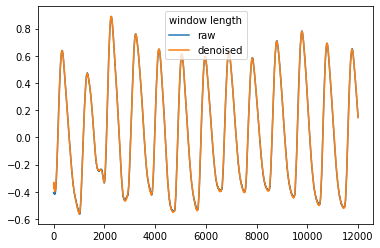

In [5]:
%%time
denoised_ppg = wavelet_denoise_swt(p3_signal.PPG[:120000]) # testing function on 2 mins (1000 hz * 120 seconds)
plot_signal(p3_signal.PPG[:12000], "raw")
plot_signal(denoised_ppg[:12000], "denoised")

(abs(p3_signal.PPG[:120000]-denoised_ppg[120000])).describe() # difference between

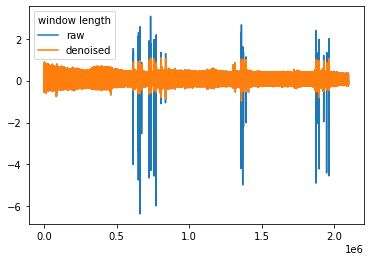

In [6]:
# comparing signal raw and denoised
denoised_ppg = wavelet_denoise_swt(p3_signal.PPG)
plot_signal(p3_signal.PPG, "raw")
plot_signal(denoised_ppg, "denoised")

# on entire signal

# Discrete Wavelet Transform (DWT on ECG)

In [7]:
def wavelet_denoise_dwt(sig, wavelet="db4", level=8, mode="hard"): # default settings for ECG
    # pad to ensure that the number of signal samples is a power of 2.
    sig = np.pad(sig, (0, 2**int(np.ceil(np.log2(len(sig)))) - len(sig)), "constant")

#     # applying DWT using pywavelet
#     dwt_orig_coeffs = wavedec(sig, wavelet=wavelet, level=level)
#     dwt_coeffs_copy = deepcopy(dwt_orig_coeffs)
    
    denoised = denoise_wavelet(sig, wavelet=wavelet, mode=mode, wavelet_levels=level)
    
    return denoised  

In [8]:
%%time
denoised_ecg = wavelet_denoise_dwt(p3_signal.ECG[:120000])

CPU times: user 10.7 ms, sys: 160 µs, total: 10.9 ms
Wall time: 29.2 ms


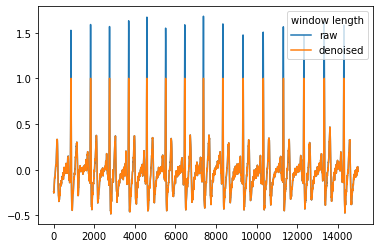

In [9]:
# comparing signal raw and denoised
plot_signal(p3_signal.ECG[:15000], "raw")
plot_signal(denoised_ecg[:15000], "denoised")

/opt/anaconda/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


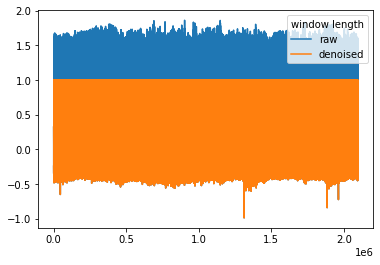

In [10]:
# comparing signal raw and denoised
denoised_ecg = wavelet_denoise_dwt(p3_signal.ECG)
plot_signal(p3_signal.ECG, "raw")
plot_signal(denoised_ecg, "denoised")

# on entire signal